#                                            Reverse Image Search

Have you ever wondered how google image search works ? or How amazon is able to retrive products similar to the image that we upload in the app/site.We will use one simple method to acomplish the task.

We will pick a pre-trained deep learnig model, remove the top layers and extract the convolutional features for the images in our dataset. Then we will use these feature vectors to find similar images by using sklearn's nearest neighbors algorithm.

<br>
<br>

#### Import libraries

In [0]:
#!pip install tqdm
#!pip install pillow
#!pip install keras --upgrade
import requests
import os
import numpy as np
from numpy.linalg import norm
import joblib as pickle
from tqdm import tqdm
import os
import PIL
import time
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import gc
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
#from tensorflow.keras.applications.MobileNet import MobileNetV2,preprocess_input
#from tensorflow.keras.applications.mobilenet import MobileNet,preprocess_input
import math
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.decomposition import PCA

In [0]:
# If you are using tensorflow 2.x and run into memory issues uncomment below lines.
#config = tf.compat.v1.ConfigProto()
#config.gpu_options.allow_growth = True
#session = tf.compat.v1.InteractiveSession(config=config)

We will be using Caltech101 object dataset. A small description about the dataset -  Pictures of objects belonging to 101 categories. About 40 to 800 images per category. Most categories have about 50 images. Collected in September 2003 by Fei-Fei Li, Marco Andreetto, and Marc 'Aurelio Ranzato.  The size of each image is roughly 300 x 200 pixels.

To know more about the dataset - http://www.vision.caltech.edu/Image_Datasets/Caltech101/

#### Download the Data

In [3]:
url = 'http://www.vision.caltech.edu/Image_Datasets/Caltech101/101_ObjectCategories.tar.gz'
r = requests.get(url)
filename = '101_ObjectCategories.tar.gz'
folderdername = filename.split('.')[0]
open(filename , 'wb').write(r.content)


131740031

In [0]:

# reference https://stackoverflow.com/questions/30887979/i-want-to-create-a-script-for-unzip-tar-gz-file-via-python
import tarfile
if filename.endswith("tar.gz"):
    tar = tarfile.open(filename, "r:gz")
    tar.extractall()
    tar.close()
elif filename.endswith("tar"):
    tar = tarfile.open(filename, "r:")
    tar.extractall()
    tar.close()


In [0]:
 #Remove the folder 'Background google' as it doesn't contain valid infromation
#!rm -rf  '101_ObjectCategories/BACKGROUND_Google' #Linux
#os.removedirs('101_ObjectCategories/BACKGROUND_Google') #windows

<br>
We will be using Resnet50 model which is pretrained on imagenet dataset (http://www.image-net.org/) to extract the features from the images. Inother words we will convert the images in the dataset to feature vectors using Resnet50.
<br>
<br>


### Why resnet ? 

We picked resnet because of the relatively small features size. It converts images into 2048 convoltional features compared to 25088 features in vgg 19 or 51200 featues in inception architectures. It will be easy for nearest neighbours algorithm to find neighbours and also it will minimize the effects of Curse_of_dimensionality. https://en.wikipedia.org/wiki/Curse_of_dimensionality
 

Create Resnet50 model without top layers so we get convolutional features as output instead of the image classification probability.

In [22]:
img_size =224

model = ResNet50(weights='imagenet', include_top=False,input_shape=(img_size, img_size, 3),pooling='max')

94773248/94765736 [==============================] - 1s 0us/step


Create the keras image data generator object and extract the features for the images using Resnet50 predict_generator method.

In [23]:
batch_size = 64
root_dir = '101_ObjectCategories'

img_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

datagen = img_gen.flow_from_directory(root_dir,
                                        target_size=(img_size, img_size),
                                        batch_size=batch_size,
                                        class_mode=None,
                                        shuffle=False)

num_images = len(datagen.filenames)
num_epochs = int(math.ceil(num_images / batch_size))

feature_list = model.predict_generator(datagen, num_epochs)

Found 8677 images belonging to 101 classes.
Instructions for updating:
Please use Model.predict, which supports generators.


In [24]:
print("Num images   = ", len(datagen.classes))
print("Shape of feature_list = ", feature_list.shape)

Num images   =  8677
Shape of feature_list =  (8677, 2048)


We have 9144 images in our dataset after removing the google backgroud images. Each images is converted into a 2048 feature vector.

In [0]:
# Get full path for all the images in our dataset

filenames = [root_dir + '/' + s for s in datagen.filenames]

We will fit the nearest neighbours algorithm to the extracted features. We picked ball_tree algorithm as it works well with sparse data.

In [26]:
neighbors = NearestNeighbors(n_neighbors=5,
                             algorithm='ball_tree',
                             metric='euclidean')
neighbors.fit(feature_list)

NearestNeighbors(algorithm='ball_tree', leaf_size=30, metric='euclidean',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

Let's pick a new image which is not present in our dataset and try to find similar images for it

In [29]:
from google.colab import files
uploaded = files.upload()

Saving ant.jpg to ant.jpg


In [0]:
img_path = 'ant.jpg'
# ref https://datascience.stackexchange.com/questions/31167/how-to-predict-an-image-using-saved-model
input_shape = (img_size, img_size, 3)
img = image.load_img(img_path, target_size=(input_shape[0], input_shape[1]))
img_array = image.img_to_array(img)
expanded_img_array = np.expand_dims(img_array, axis=0)
preprocessed_img = preprocess_input(expanded_img_array)


In [0]:
test_img_features = model.predict(preprocessed_img, batch_size=1)

_, indices = neighbors.kneighbors(test_img_features)

(1, 5)


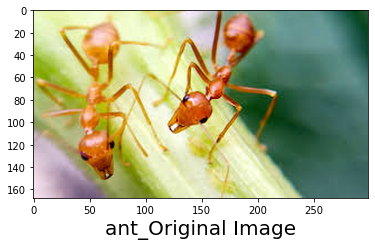

********* Predictions ***********


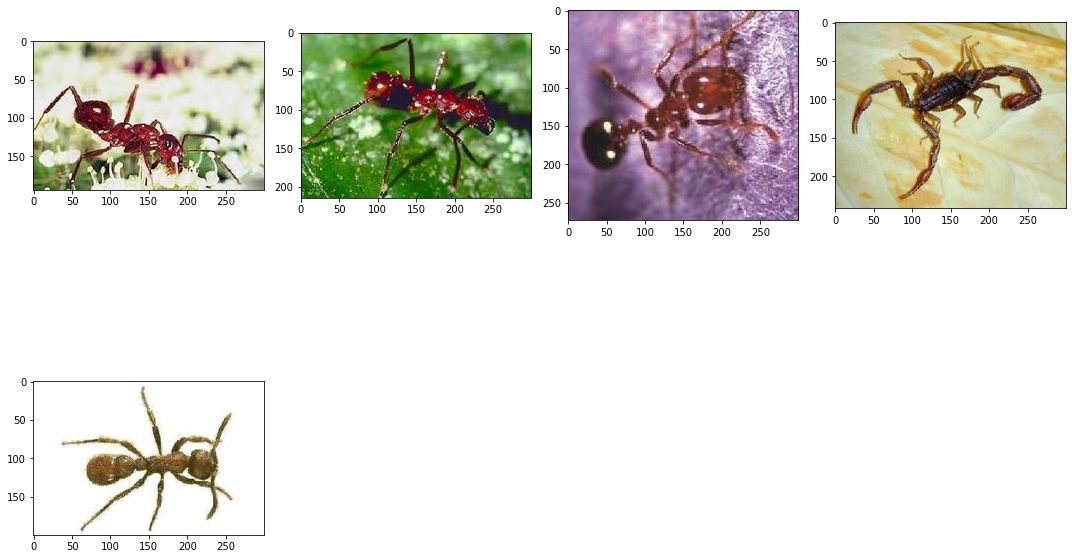

In [32]:
def similar_images(indices):
    plt.figure(figsize=(15,10), facecolor='white')
    plotnumber = 1    
    for index in indices:
        if plotnumber<=len(indices) :
            ax = plt.subplot(2,4,plotnumber)
            plt.imshow(mpimg.imread(filenames[index]), interpolation='lanczos')            
            plotnumber+=1
    plt.tight_layout()

print(indices.shape)

plt.imshow(mpimg.imread(img_path), interpolation='lanczos')
plt.xlabel(img_path.split('.')[0] + '_Original Image',fontsize=20)
plt.show()
print('********* Predictions ***********')
similar_images(indices[0])

There is an scorpion image in the predictions which is wrong. Due to the large demnetionatliy of the features, the NearestNeighbors algorithm is not able cluster the similar features accurately .
<br>

We will apply PCA to our features and reduce the dimentions and try to predict the similar features again.

In [0]:
pca = PCA(n_components=100)
pca.fit(feature_list)
compressed_features = pca.transform(feature_list)

In [0]:
neighbors_pca_features = NearestNeighbors(n_neighbors=5,
                             algorithm='ball_tree',
                             metric='euclidean').fit(compressed_features)

(1, 5)


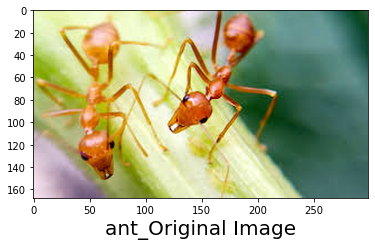

********* Predictions ***********


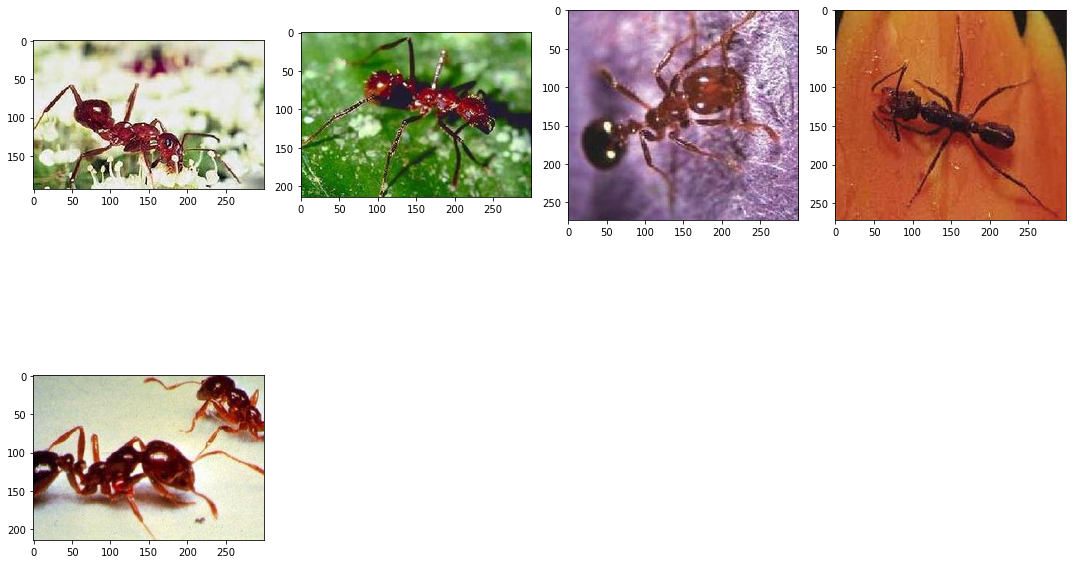

In [35]:
img_path = 'ant.jpg'

input_shape = (img_size, img_size, 3)
img = image.load_img(img_path, target_size=(input_shape[0], input_shape[1]))
img_array = image.img_to_array(img)
expanded_img_array = np.expand_dims(img_array, axis=0)
preprocessed_img = preprocess_input(expanded_img_array)

result = model.predict(preprocessed_img, batch_size=1)
result_compressed = pca.transform(result)
distances, indices = neighbors_pca_features.kneighbors(result_compressed)
print(indices.shape)
plt.imshow(mpimg.imread(img_path), interpolation='lanczos')
plt.xlabel(img_path.split('.')[0] + '_Original Image',fontsize=20)
plt.show()
print('********* Predictions ***********')
similar_images(indices[0])

Great ! reducing the dimensions of the features helped in getting better results.

### What next ?


*   Try different pre-trained models like mobilenet,vgg16 etc. and check the accuracy
*   Try data agumention on the dataset.
*   We have used n_componets in PCA is 100. We can try to changing these numbers and see how it effects our predictions.



